# Textual Analysis of Twitter Feeds For Financial Companies
### Group Project for Introduction to Data Science
Group Members:
1. Zeyu Meng  
2. Xi Mei   
3. Siddharth Uppal       


## Introduction:
- The central business problem is to understand and monitor in the stock prices of various bank institutions using developments via twitter feeds. 
- Many companies are interested in monitor their interests to gain exponential returns on their investments. Twitter is one of the platforms where the news spreads like fire. 
- Companies need to tap into incoming news/twitter feeds  to understand what developments can influence their investments. 
- FinTech companies can track important positive and negative twitter feeds to save their interest.  

### Part 1: Loughran&McDonald dictionary
- Import the Loughran&McDonald dictionary into a dataframe.
- Build lists for each feature. The features include 'Negative', 'Positive', 'Modal1', etc.in Loughran&McDonald dictionary

In [1]:
import pandas as pd
dictionary=pd.read_csv("Dictionary.csv")

Negative=list(dictionary[dictionary.Negative>0]["Word"])
Positive=list(dictionary[dictionary.Positive>0]["Word"])
Uncertainty=list(dictionary[dictionary.Uncertainty>0]["Word"])
Litigious=list(dictionary[dictionary.Litigious>0]["Word"])
Constraining=list(dictionary[dictionary.Constraining>0]["Word"])
Superfluous=list(dictionary[dictionary.Superfluous>0]["Word"])
Interesting=list(dictionary[dictionary.Interesting>0]["Word"])
Modal1=list(dictionary[dictionary.Modal==1]["Word"])
Modal2=list(dictionary[dictionary.Modal==2]["Word"])
Modal3=list(dictionary[dictionary.Modal==3]["Word"])

dictionary.head()

,Word,Sequence Number,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Constraining,Superfluous,Interesting,Modal,Irr_Verb,Harvard_IV,Syllables,Source
0,AARDVARK,1,81,5.690000e-09,3.070000e-09,5.780000e-07,45,0,0,0,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,2,1.400000e-10,8.220000e-12,7.840000e-09,1,0,0,0,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,8,5.620000e-10,1.690000e-10,7.100000e-08,7,0,0,0,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,5,3.510000e-10,1.730000e-10,7.530000e-08,5,0,0,0,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,1752,1.230000e-07,1.200000e-07,1.110000e-05,465,0,0,0,0,0,0,0,0,0,0,3,12of12inf


 ### Part 2: Twitter's Data
- Download Twitter's data from Twitter's API into a database built by us.
- Query the database and count the number of each features for each piece of tweet during a period of time. 

In [2]:
import numpy as np
import urllib
import datetime as dt
import matplotlib.pyplot as plt
import re
from datetime import datetime
from elasticsearch import Elasticsearch
es = Elasticsearch(["http://search-banktweets-oe3qkimmg7aavxn2djiwrm5bi4.us-east-1.es.amazonaws.com:80"])

#This function is just used to transfer time stamp into standard time.
def timetransfer(ts):
    return datetime.fromtimestamp(ts/1000+600).strftime('%Y-%m-%d %H:%M:%S')

def get_twitter_data(banksname):
    
    #Query twitters data from a database. 
    res=es.search(index="banktweets", doc_type="tweets",scroll="1m",body={"from":0, "size":100, "query": {"match": {"text":banksname}}})
    scrollId=res["_scroll_id"]
    dataset=[]
    scrollres=es.scroll(scroll_id=scrollId,scroll="1m") 
    
    #Count the number of each features for each piece of tweet during a period of time. 
    while( len(scrollres["hits"]["hits"])>0):    
        for hit in scrollres['hits']['hits']:
            neg,pos,unc,lit,con,sup,intr,mod1,mod2,mod3=0,0,0,0,0,0,0,0,0,0
            p = re.compile("[^a-zA-Z]?")
            stringArray=p.split(hit["_source"]["text"])
            for word in stringArray:
                WORD=word.upper()
                if WORD in Negative: neg=neg+1
                if WORD in Positive: pos=pos+1
                if WORD in Uncertainty: unc=unc+1
                if WORD in Litigious: lit=lit+1
                if WORD in Constraining: con=con+1
                if WORD in Superfluous: sup=sup+1
                if WORD in Interesting: intr=intr+1
                if WORD in Modal1: mod1=mod1+1
                if WORD in Modal2: mod2=mod2+1
                if WORD in Modal3: mod3=mod3+1
            array=[hit["_source"]["time"],neg,pos,unc,lit,con,sup,intr,mod1,mod2,mod3]
            dataset.append(array)
        scrollres=es.scroll(scroll_id=scrollId,scroll="1m")
    df=pd.DataFrame(dataset,columns=['timestamp','neg', 'pos', 'unc', 'lit', 'con','sup','intr','Mod1','Mod2','Mod3'])
    
    #Transfer the timestamp into standard time
    df["time"]=df["timestamp"].map(lambda t:timetransfer(t))
    
    #Sum up the number of each feature for all tweets in each period with a fixed time range.
    df=df.set_index(pd.DatetimeIndex(df['time'])).sort_index().drop("timestamp",axis=1)
    df["count"]=1
    df=df.resample("5T").sum()
    return df

 ### Part 3: Google Finance's Data
- Query Google Fiance's data online, which include open prices, highest prices, lowest prices, close prices, volumes of stocks during one particular moment.
- Compile Google Fiance's data and prepare them for matching with Twitter's data. 

In [3]:
def get_google_data(symbol, period, window):
    url_root = 'http://www.google.com/finance/getprices?i='
    url_root += str(period) + '&p=' + str(window)
    url_root += 'd&f=d,o,h,l,c,v&df=cpct&q=' + symbol
    response = urllib.request.urlopen(url_root)
    data = str(response.read()).split('\\n')
    #actual data starts at index = 7
    #first line contains full timestamp,
    #every other line is offset of period from timestamp
    parsed_data = []
    anchor_stamp = ''
    end = len(data)
    for i in range(7, end):
        cdata = data[i].split(',')
        if 'a' in cdata[0]:
    #first one record anchor timestamp
            anchor_stamp = cdata[0].replace('a', '')
            cts = int(anchor_stamp)
        else:
            try:
                coffset = int(cdata[0])
                cts = int(anchor_stamp) + (coffset * period)
                parsed_data.append((dt.datetime.fromtimestamp(float(cts)), float(cdata[1]), float(cdata[2]), float(cdata[3]), float(cdata[4]), float(cdata[5])))
            except:
                pass # for time zone offsets thrown into data
    df = pd.DataFrame(parsed_data)
    df.columns = ['ts', 'o', 'h', 'l', 'c', 'v']
    df.index = df.ts
    del df['ts']
    return df 

 ### Part 4: Matching Google Finance's Data with Tiwtter's Data
- Set the target values as 'close prices minus open prices' for each company's stocks during a particular moment. 
- Transfer the target values into binary. 1 means increase and 0 means either decrease or netural.

In [4]:
Banksname={'Bank of America':'BAC','CitiGroup':'C','Goldman Sachs':'GS',
           'JPMorgan Chase':'JPM','Morgan Stanley':'MS','Wells Fargo':'WFC'}
Banksdata=dict()

def binary(v):
    if(v>0):
        return 1
    else:
        return 0
    
for name, symbol in Banksname.items():
    Googledata=get_google_data(symbol, 300, 14)
    Googledata["C-O"]=Googledata["c"]-Googledata["o"]
    #Set the target values as 'close prices minus open prices' and Transfer the target values into binary.
    Googledata["Target"]=Googledata["C-O"].map(lambda t:binary(t))
    Twitterdata=get_twitter_data(name)
    Bankdata=Googledata.join(Twitterdata,how="left").dropna().drop(["o","h","l","c","v","C-O"],axis=1)
    Banksdata[name]=Bankdata

E:\Study\Python\Anaconda03\lib\site-packages\ipykernel\__main__.py:27: FutureWarning: split() requires a non-empty pattern match.


 ### Part 5: Model Fitting
 - Shuffle organized data and kfold them for k=5.
 - Fit the data to DecisionTree, LogisticRegression and SVC models.
 - Plot them up and see the AUC results for each of them.

- DecisionTree

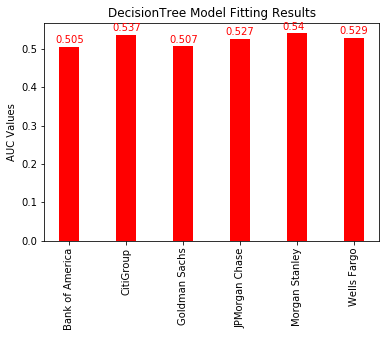

In [61]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

results_AUC=dict()

#This is our items of parameters and their ranges.  
param_grid_dt = {'min_samples_split':[20*i for i in range(1, 10)], 'min_samples_leaf':[i*2 for i in range(1, 10)],'criterion':['entropy','gini']}

for name,data in Banksdata.items():
    data_shuf=data.reindex(np.random.permutation(data.index))
    kfolds = KFold(data_shuf.shape[0], n_folds = 5)
    X=data_shuf.drop('Target', 1)
    Y=data_shuf['Target']
    dt_grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv = kfolds, scoring = 'roc_auc') 
    dt_grid_search.fit(X, Y)
    results_AUC[name]= dt_grid_search.best_score_

#Plot the results.    
fig, ax = plt.subplots()
width = 0.35

ax.bar(np.arange(6), results_AUC.values(), width, color = 'r')
ax.set_xticks(np.arange(len(results_AUC.keys())))
ax.set_xticklabels(results_AUC.keys(), rotation = 90)
plt.title('DecisionTree Model Fitting Results')
ax.set_ylabel('AUC Values') 
for i, v in enumerate(results_AUC.values()):
    ax.text(i-0.25 , v+0.01, str(round(v, 3)), color='r')

- LogisticRegression

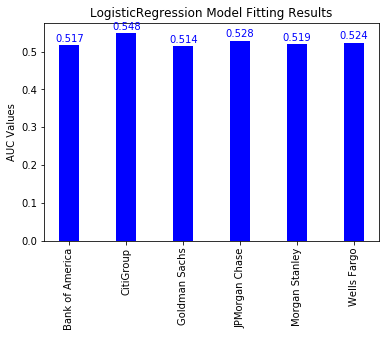

In [62]:
from sklearn.linear_model import LogisticRegression
%matplotlib inline

results_AUC=dict()

#This is our items of parameters and their ranges.  
param_grid_lr = {'C':[10**i for i in range(-10, 10)], 'penalty':['l1','l2']}

for name,data in Banksdata.items():
    data_shuf=data.reindex(np.random.permutation(data.index))
    kfolds = KFold(data_shuf.shape[0], n_folds = 5)
    X=data_shuf.drop('Target', 1)
    Y=data_shuf['Target']
    lr_grid_search = GridSearchCV(LogisticRegression(), param_grid_lr, cv = kfolds, scoring = 'roc_auc') 
    lr_grid_search.fit(X, Y)
    results_AUC[name]= lr_grid_search.best_score_

#Plot the results.
fig, ax = plt.subplots()
width = 0.35

ax.bar(np.arange(6), results_AUC.values(), width, color = 'blue')
ax.set_xticks(np.arange(len(results_AUC.keys())))
ax.set_xticklabels(results_AUC.keys(), rotation = 90)
plt.title('LogisticRegression Model Fitting Results')
ax.set_ylabel('AUC Values')
for i, v in enumerate(results_AUC.values()):
    ax.text(i-0.25 , v+0.01, str(round(v, 3)), color='blue')

- SVC

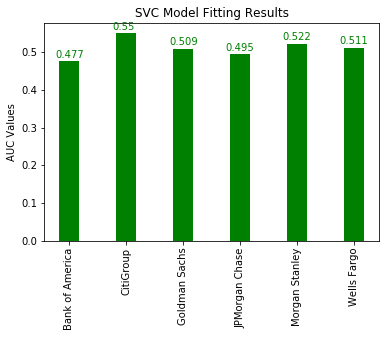

In [63]:
from sklearn.svm import SVC
%matplotlib inline

results_AUC=dict()

#This is our items of parameters and their ranges.  
param_grid_svc = {'C':[10**i for i in range(-3, 3)], 'kernel':['linear']}

for name,data in Banksdata.items():
    data_shuf=data.reindex(np.random.permutation(data.index))
    kfolds = KFold(data_shuf.shape[0], n_folds = 5)
    X=data_shuf.drop('Target', 1)
    Y=data_shuf['Target']
    svc_grid_search = GridSearchCV(SVC(), param_grid_svc, cv = kfolds, scoring = 'roc_auc') 
    svc_grid_search.fit(X, Y)
    results_AUC[name]= svc_grid_search.best_score_

#Plot the results.
fig, ax = plt.subplots()
width = 0.35

ax.bar(np.arange(6), results_AUC.values(), width, color = 'green')
ax.set_xticks(np.arange(len(results_AUC.keys())))
ax.set_xticklabels(results_AUC.keys(), rotation = 90)
plt.title('SVC Model Fitting Results')
ax.set_ylabel('AUC Values')
for i, v in enumerate(results_AUC.values()):
    ax.text(i-0.25 , v+0.01, str(round(v, 3)), color='green')

### Part 6: Model Fitting for Top3 Important Features
 - Work out the top3 important features by DecisionTree model based on 'Bank of America' data.
 - Repeat Part 5 once again with only top3 important features.

In [67]:
Data=Banksdata['Bank of America']
Data_shuf=Data.reindex(np.random.permutation(Data.index))
kfolds = KFold(Data_shuf.shape[0], n_folds = 5)
X = Data_shuf.drop('Target', 1)
Y = Data_shuf['Target']

dt_grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv = kfolds, scoring = 'roc_auc') 
dt_grid_search.fit(X, Y)
print(dt_grid_search.best_estimator_)
print('Best_score={}'.format(dt_grid_search.best_score_))

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Best_score=0.5331556142313822


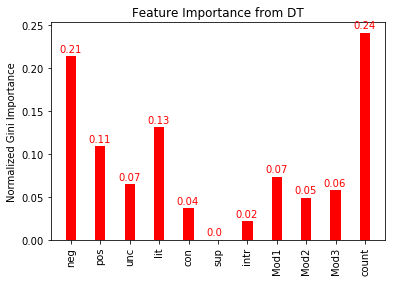

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
width = 0.35

clf = DecisionTreeClassifier(criterion='entropy',min_samples_split=20,min_samples_leaf=2)
clf = clf.fit(X,Y)

ax.bar(np.arange(11), clf.feature_importances_, width, color = 'r')
ax.set_xticks(np.arange(len(clf.feature_importances_)))
ax.set_xticklabels(X.columns.values, rotation = 90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')
for i, v in enumerate(clf.feature_importances_):
    ax.text(i-0.4 , v+0.005, str(round(v, 2)), color='r')

- DecisionTree with Top3 Important Features

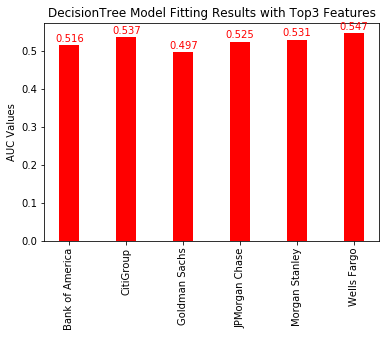

In [69]:
%matplotlib inline

results_AUC=dict()

for name,data in Banksdata.items():
    data_shuf=data.reindex(np.random.permutation(data.index))
    kfolds = KFold(data_shuf.shape[0], n_folds = 5)
    X=data_shuf[['neg','count','lit']]
    Y=data_shuf['Target']
    dt_grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv = kfolds, scoring = 'roc_auc') 
    dt_grid_search.fit(X, Y)
    results_AUC[name]= dt_grid_search.best_score_

fig, ax = plt.subplots()
width = 0.35

ax.bar(np.arange(6), results_AUC.values(), width, color = 'r')
ax.set_xticks(np.arange(len(results_AUC.keys())))
ax.set_xticklabels(results_AUC.keys(), rotation = 90)
plt.title('DecisionTree Model Fitting Results with Top3 Features')
ax.set_ylabel('AUC Values') 
for i, v in enumerate(results_AUC.values()):
    ax.text(i-0.25 , v+0.01, str(round(v, 3)), color='r')

- LogisticRegression with Top3 Important Features

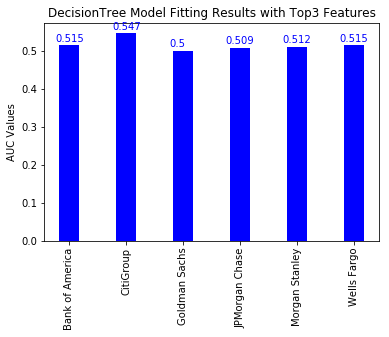

In [70]:
%matplotlib inline

results_AUC=dict()

for name,data in Banksdata.items():
    data_shuf=data.reindex(np.random.permutation(data.index))
    kfolds = KFold(data_shuf.shape[0], n_folds = 5)
    X=data_shuf[['neg','count','lit']]
    Y=data_shuf['Target']
    lr_grid_search = GridSearchCV(LogisticRegression(), param_grid_lr, cv = kfolds, scoring = 'roc_auc') 
    lr_grid_search.fit(X, Y)
    results_AUC[name]= lr_grid_search.best_score_

fig, ax = plt.subplots()
width = 0.35

ax.bar(np.arange(6), results_AUC.values(), width, color = 'blue')
ax.set_xticks(np.arange(len(results_AUC.keys())))
ax.set_xticklabels(results_AUC.keys(), rotation = 90)
plt.title('DecisionTree Model Fitting Results with Top3 Features')
ax.set_ylabel('AUC Values') 
for i, v in enumerate(results_AUC.values()):
    ax.text(i-0.25 , v+0.01, str(round(v, 3)), color='blue')

- SVC with Top3 Important Features

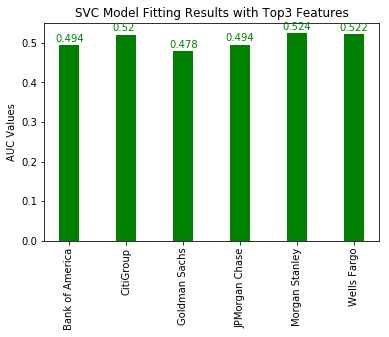

In [71]:
%matplotlib inline

results_AUC=dict()

for name,data in Banksdata.items():
    data_shuf=data.reindex(np.random.permutation(data.index))
    kfolds = KFold(data_shuf.shape[0], n_folds = 5)
    X=data_shuf[['neg','count','lit']]
    Y=data_shuf['Target']
    svc_grid_search = GridSearchCV(SVC(), param_grid_svc, cv = kfolds, scoring = 'roc_auc') 
    svc_grid_search.fit(X, Y)
    results_AUC[name]= svc_grid_search.best_score_

fig, ax = plt.subplots()
width = 0.35

ax.bar(np.arange(6), results_AUC.values(), width, color = 'green')
ax.set_xticks(np.arange(len(results_AUC.keys())))
ax.set_xticklabels(results_AUC.keys(), rotation = 90)
plt.title('SVC Model Fitting Results with Top3 Features')
ax.set_ylabel('AUC Values')    
for i, v in enumerate(results_AUC.values()):
    ax.text(i-0.25 , v+0.01, str(round(v, 3)), color='green')

### Part 7: Combining All Banks' Data
 - Combine all banks' data in one dataframe.
 - Use these three models to fit the combined data.

In [72]:
df_bank=pd.DataFrame()
for name,data in Banksdata.items():
    df_bank=df_bank.append(data,ignore_index=True)
data_shuf=df_bank.reindex(np.arange(len(df_bank.index)))
data_shuf=df_bank.reindex(np.random.permutation(df_bank.index))
kfolds = KFold(data_shuf.shape[0], n_folds = 5)
X = data_shuf.drop('Target', 1)
Y = data_shuf['Target']

dt_grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv = kfolds, scoring = 'roc_auc') 
dt_grid_search.fit(X, Y)
print('Best Score for DecisionTree is {}'.format(dt_grid_search.best_score_))

Best Score for DecisionTree is 0.5117453350355196


In [73]:
lr_grid_search = GridSearchCV(LogisticRegression(), param_grid_lr, cv = kfolds, scoring = 'roc_auc') 
lr_grid_search.fit(X, Y)
print('Best Score for LogisticRegression is {}'.format(lr_grid_search.best_score_))

Best Score for LogisticRegression is 0.5


In [74]:
param_grid_svc = {'C':[10**i for i in range(-1, 1)], 'kernel':['linear']}

svc_grid_search = GridSearchCV(SVC(), param_grid_svc, cv = kfolds, scoring = 'roc_auc') 
svc_grid_search.fit(X, Y)
print('Best Score for SVC is {}'.format(svc_grid_search.best_score_))

Best Score for SVC is 0.4985581072653837


### Part 8: Combined Banks' Data With Only Top3 Important Features
 - Fit combined banks' data to models with only top3 important features.

In [75]:
X=X[['neg','count','lit']]
dt_grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv = kfolds, scoring = 'roc_auc') 
dt_grid_search.fit(X, Y)
print('Best Score for DecisionTree is {} for top3 important features'.format(dt_grid_search.best_score_))

Best Score for DecisionTree is 0.5129088095366596 for top3 important features


In [76]:
lr_grid_search = GridSearchCV(LogisticRegression(), param_grid_lr, cv = kfolds, scoring = 'roc_auc') 
lr_grid_search.fit(X, Y)
print('Best Score for LogisticRegression is {} for top3 important features'.format(lr_grid_search.best_score_))

Best Score for LogisticRegression is 0.5 for top3 important features


In [77]:
param_grid_svc = {'C':[10**i for i in range(-1, 1)], 'kernel':['linear']}

svc_grid_search = GridSearchCV(SVC(), param_grid_svc, cv = kfolds, scoring = 'roc_auc') 
svc_grid_search.fit(X, Y)
print('Best Score for SVC is {} for top3 important features'.format(svc_grid_search.best_score_))

Best Score for SVC is 0.5008092303782022 for top3 important features


## Conclusion:
![Screenshot](Excel File.png)
- The yellow highlight part is the best fitting case for each bank.  Through the table showed above, we can conclude that for textual analysis of twitter feeds for financial companies, the statistically best method is to use all features fitting Logistic Regression model.
- Our target value is binary. It’s either 0(prices go down or keep neutral) or 1(prices go up). The model solves the problems as it can give a binary estimated result based on tweets collected in a particular period of moment. The binary estimated result tells us whether the stock prices will go up or go down.  

## Possible Further Improvements
- The model’s accuracy depends on the size of the data set. Currently 263417+ tweets were used for the analysis of the models that can predict the stock prices of the banks that we were interested in. The larger the data set, larger duration of prediction by the models is required. 
- Besides that the financial dictionary needs to be updated regularly, whithout which some termalogies may cause offsetting of prediction models. 
- Furthermore, various combination of features can lead to different fitting results. Based on updated dictionaries, we can work out the best combination of features for model fitting. 
- Thus the further improvements could be increasing the size of data sets, updating the financial dictionary or using the best combination of features. 